<a href="https://colab.research.google.com/github/laurelkeys/machine-learning/blob/master/assignment-4/Trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# PATH_TO_DATA = os.path.join("drive", "My Drive", "unicamp", "MC886", "atari")

import os
PATH_TO_DATA = ""

In [4]:
SAVE_DIR = os.path.join(PATH_TO_DATA, "data")
os.makedirs(SAVE_DIR, exist_ok=True)

SAVE_DIR

'data'

## Generate a dataset of trajectories from pre-trained RL agents on [Atari](https://gym.openai.com/envs/#atari) [environments](https://github.com/openai/gym/wiki/Table-of-environments).
That is, by the end of this notebook we will have $observation \rightarrow action$ mappings, where $observation$s are images of shape `IMG_SHAPE` and $action$s are integer values in the range $[0, 18)$, meaning:

| 0 | 1 | 2 | 3 | 4 | 5 |
| --- | --- | --- | --- | --- | --- |
| NOOP | FIRE | UP | RIGHT | LEFT | DOWN |


| 6 | 7 | 8 | 9 |
| --- | --- | --- | --- |
| UPRIGHT | UPLEFT | DOWNRIGHT | DOWNLEFT |


| 10 | 11 | 12 | 13 |
| --- | --- | --- | --- |
| UPFIRE | RIGHTFIRE | LEFTFIRE | DOWNFIRE |


| 14 | 15 | 16 | 17 |
| --- | --- | --- | --- |
| UPRIGHTFIRE | UPLEFTFIRE | DOWNRIGHTFIRE | DOWNLEFTFIRE |

In [0]:
# number of trajectories to generate
N_OF_TRAJECTORIES = 2

# number of steps per trajectory
N_OF_STEPS = 250

# # list of string tuples in the format (RL Algorithm, Game Environment)
GAMES = [
    ("PPO2", "BreakoutNoFrameskip-v4"),
    ("PPO2", "PongNoFrameskip-v4"),
]

In [6]:
[env_id for algo, env_id in GAMES]

['BreakoutNoFrameskip-v4', 'PongNoFrameskip-v4']

[RL Baselines Zoo](https://github.com/araffin/rl-baselines-zoo) currently has the following environments with `PPO2` pre-trained agents:  
`BeamRiderNoFrameskip-v4`, `BreakoutNoFrameskip-v4`, `EnduroNoFrameskip-v4`, `MsPacmanNoFrameskip-v4`, `PongNoFrameskip-v4`, `QbertNoFrameskip-v4`, `SeaquestNoFrameskip-v4`, `SpaceInvadersNoFrameskip-v4`

## Install dependencies

Note that we're not installing MPI, so the following algorithms will probably not work: `DDPG`, `GAIL`, `PPO1`, `TRPO`.

In [0]:
!apt-get update                                                  > /dev/null 2>&1
!apt-get install swig cmake zlib1g-dev ffmpeg freeglut3-dev xvfb > /dev/null 2>&1
!pip install pyyaml pytablewriter optuna scikit-optimize         > /dev/null 2>&1

In [8]:
#### Stable Baselines only supports TF 1.x for now ####
try:
    # Colab only
    # %tensorflow_version 2.x
    %tensorflow_version 1.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

1.15.0


In [0]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from gym.envs.atari.atari_env import ACTION_MEANING

### Clone [Stable Baselines](https://github.com/hill-a/stable-baselines) and [RL Zoo Baselines](https://github.com/araffin/rl-baselines-zoo)

In [10]:
!pip list | grep baselines

stable-baselines         2.2.1      


In [0]:
!yes | pip uninstall stable-baselines                           > /dev/null 2>&1
!pip install git+https://github.com/hill-a/stable-baselines.git > /dev/null 2>&1

In [12]:
!pip list | grep baselines

stable-baselines         2.9.0a0    


In [13]:
!git clone https://github.com/araffin/rl-baselines-zoo.git

Cloning into 'rl-baselines-zoo'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 1539 (delta 8), reused 15 (delta 3), pack-reused 1514
Receiving objects: 100% (1539/1539), 375.51 MiB | 40.31 MiB/s, done.
Resolving deltas: 100% (891/891), done.
Checking out files: 100% (305/305), done.


In [14]:
from stable_baselines.common.cmd_util import make_atari_env

from stable_baselines.common.vec_env import VecFrameStack

# NOTE add more algorithms here
from stable_baselines import PPO2, ACER, ACKTR
ALGO_IMPL = {
    'PPO2': PPO2,
    'ACER': ACER,
    'ACKTR': ACKTR,
}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Load the pre-trained agents

In [15]:
!ls rl-baselines-zoo/

benchmark.md  images	 run_docker_cpu.sh  tests
docker	      LICENSE	 run_docker_gpu.sh  trained_agents
enjoy.py      logs	 scripts	    train.py
hyperparams   README.md  setup.cfg	    utils


In [0]:
PATH_TO_AGENTS = os.path.join("rl-baselines-zoo", "trained_agents")

In [41]:
print("================")
for algo, env_id in GAMES:
    env = make_atari_env(env_id, num_env=1, seed=0)
    env = VecFrameStack(env, n_stack=4)
    print(f"('{algo}', '{env_id}')")
    
    agent_path = os.path.join(PATH_TO_AGENTS, algo.lower(), env_id + '.pkl')
    print(f"Getting pre-trained agent from: '{agent_path}'\n")
    
    model = ALGO_IMPL[algo].load(agent_path, env)
    
    for trajectory in range(N_OF_TRAJECTORIES):
        # store the "obs -> action" mapping
        observed_states, actions_taken = [], []

        # each frame is converted to grayscale 
        # and downscaled from 210x160 to 84x84
        obs = env.reset() # (84, 84, 4) four stacked frames
        for step in range(N_OF_STEPS):
            action = model.predict(obs)

            observed_states.append(obs)
            actions_taken.append(action)

            # NOTE action, reward and done are arrays since we're using a vectorized env
            obs, reward, done, info = env.step(action)
            if done:
                print(f"done at step {step + 1} (reseting env)")
                obs = env.reset()
        
        # print("\ne.g.: observed_states[0].shape:", observed_states[0].shape, end=' ')
        observed_states = [obs[0] for obs in observed_states]
        # print("->", observed_states[0].shape)
        # print("      actions_taken[0]:", actions_taken[0], end=' ')
        actions_taken = [action[0][0] for action in actions_taken]
        # print("->", actions_taken[0])
        
        np.savez_compressed(
                file=os.path.join(SAVE_DIR, f"{env_id}_{algo}_t{trajectory+1}_{N_OF_STEPS}s"), 
                observations=observed_states, 
                actions=actions_taken)
        print(f"Saved trajectory {trajectory+1} (of {N_OF_TRAJECTORIES})")

        if trajectory == N_OF_TRAJECTORIES - 1:
            print("\nActions taken:", ", ".join([ACTION_MEANING[action] for action in set(actions_taken)]))

    del observed_states
    del actions_taken
    env.close()
    print("================")


('PPO2', 'BreakoutNoFrameskip-v4')
Getting pre-trained agent from: 'rl-baselines-zoo/trained_agents/ppo2/BreakoutNoFrameskip-v4.pkl'

Saved trajectory 1 (of 2)
Saved trajectory 2 (of 2)

Actions taken: NOOP, FIRE, UP, RIGHT
('PPO2', 'PongNoFrameskip-v4')
Getting pre-trained agent from: 'rl-baselines-zoo/trained_agents/ppo2/PongNoFrameskip-v4.pkl'

Saved trajectory 1 (of 2)
Saved trajectory 2 (of 2)

Actions taken: NOOP, FIRE, UP, RIGHT, LEFT, DOWN


In [58]:
for r, ds, fs in os.walk(SAVE_DIR): # r=root, d=directories, f=files
    print(r + '/')
    for f in fs:
        print("|___", f)

data/
|___ PongNoFrameskip-v4_PPO2_t2_250s.npz
|___ PongNoFrameskip-v4_PPO2_t1_250s.npy
|___ BreakoutNoFrameskip-v4_PPO2_t2_250s.npz
|___ BreakoutNoFrameskip-v4_PPO2_t2_250s.npy
|___ PongNoFrameskip-v4_PPO2_t1_250s.npz
|___ PongNoFrameskip-v4_PPO2_t2_250s.npy
|___ BreakoutNoFrameskip-v4_PPO2_t1_250s.npz
|___ BreakoutNoFrameskip-v4_PPO2_t1_250s.npy


In [59]:
test_load = np.load(os.path.join(SAVE_DIR, "PongNoFrameskip-v4_PPO2_t2_250s.npz"), allow_pickle=True)
print("observations shape:", test_load['observations'].shape)
print("actions shape:", test_load['actions'].shape)

observations shape: (250, 84, 84, 4)
actions shape: (250,)


## Old

In [0]:
# Set up display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [28]:
!pip install pyglet==1.3.1  # pyglet v1.4.1 throws an error

     |████████████████████████████████| 1.0MB 4.9MB/s 
  Found existing installation: pyglet 1.3.2
    Uninstalling pyglet-1.3.2:
      Successfully uninstalled pyglet-1.3.2


In [0]:
import os
import cv2
import gym
import random
import numpy as np
import PIL

In [0]:
# The 210x160 RGB Atari images are converted to grayscale and downsampled to 84x84
# ref.: https://github.com/hill-a/stable-baselines/blob/master/stable_baselines/common/atari_wrappers.py#L172

# INP_IMAGE_SHAPE = (84, 84)
INP_IMAGE_SHAPE = (160, 160)
INP_IMAGE_SIZE  = np.prod(INP_IMAGE_SHAPE)

In [0]:
# environments used to generate images
ENV_IDS = ["Breakout-v4"]#, "Pong-v0"]

In [0]:
PATH_TO_DATA = os.path.join("drive", "My Drive", "unicamp", "MC886", "atari")
SAVE_DIR = os.path.join(PATH_TO_DATA, "data")

IMAGES_TO_GENERATE = 1000

In [0]:
def save_as_image(observation, save_dir, img_name, prefix="img_", downscale=False):
    # downscaling the image
    if downscale:
        im_array = cv2.resize(observation, INP_IMAGE_SHAPE) # TODO test tf.image.resize
        im_array = np.array(im_array, dtype='float32')
        im_array = (im_array/127.5) - 1
        im = PIL.Image.fromarray(im_array, 'RGB')
    else:
        try:
            im = PIL.Image.fromarray(observation, 'RGB')
        except:
            print(type(observation))
    imname = "{}{}.png".format(prefix, img_name)
    im.save(os.path.join(save_dir, imname))

In [0]:
# you can change the default values here
save_dir = SAVE_DIR
num_images = IMAGES_TO_GENERATE

In [0]:
os.makedirs(save_dir, exist_ok=True)

In [0]:
envs = [gym.make(env_id) for env_id in ENV_IDS]

In [0]:
for env_id, env in zip(ENV_IDS, envs):
    print(env_id)
    env_dir = os.path.join(save_dir, f"{env_id}_{IMAGES_TO_GENERATE}")
    os.makedirs(env_dir, exist_ok=True)
    
    env.reset()
    i, current_env_images = 0, 0
    
    actions_taken = []
    while i < num_images:
        # take a random action (sampled from the action space)
        action = env.action_space.sample()
        actions_taken.append(action)
        assert 0 <= action < 18, f"action = {action}"
        obs, _, done, _ = env.step(action)
        if np.mean(obs) > 0.01:
            save_as_image(obs, env_dir, str(i))
            i += 1
        else:
            print("should I have been reached?")
            continue
        if done:
            print(f"reseting {env_id} at i={i}")
            env.reset()
    
    actions_taken = np.asarray(actions_taken, dtype='int8')
    print(actions_taken.shape, actions_taken.size, actions_taken.dtype)
    np.save(os.path.join(save_dir, f"{env_id}_{IMAGES_TO_GENERATE}_actions"), actions_taken)

Breakout-v4
reseting Breakout-v4 at i=265
reseting Breakout-v4 at i=758
reseting Breakout-v4 at i=999
(1000,) 1000 int8


In [0]:
# ref.: https://github.com/satwikkansal/atari_gan/blob/master/generate_data.py

In [0]:
# !rm -rf drive/My\ Drive/unicamp/MC886/atari/data/*.png

In [0]:
!ls -U drive/My\ Drive/unicamp/MC886/atari/data/

Breakout-v0_1000	      Pong-v0_1000_actions.npy
Breakout-v0_1000_actions.npy  Breakout-v4_1000
Pong-v0_1000		      Breakout-v4_1000_actions.npy


In [0]:
!ls -U drive/My\ Drive/unicamp/MC886/atari/data/Breakout-v4_1000/ | head -4

img_0.png
img_1.png
img_2.png
img_3.png


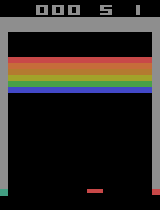

In [0]:
from IPython.display import Image
Image('drive/My Drive/unicamp/MC886/atari/data/Breakout-v4_1000/img_0.png')

In [0]:
# TODO download data/

In [0]:
actions_taken = np.load('drive/My Drive/unicamp/MC886/atari/data/Breakout-v4_1000_actions.npy')

In [0]:
print(actions_taken.shape, actions_taken.size, actions_taken.dtype)

(1000,) 1000 int8


In [0]:
actions_taken[:10]

array([3, 1, 2, 3, 1, 3, 0, 2, 2, 0], dtype=int8)

## Extract image features with [MobileNetV2](https://keras.io/applications/#mobilenetv2)

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


### Format images

In [0]:
def get_all_png(path):
    files = []
    files_full = []
    for root, dirs, file_names in os.walk(path):
        files.extend([name for name in file_names if '.png' in name.lower()])
        files_full.extend([os.path.join(root, name) for name in file_names if '.png' in name.lower()])
    return files, files_full

In [0]:
IMG_SIZE = 160 # All images will be resized to 160x160

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, image_path

### Create mobileNetV2

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 2s 0us/step


In [0]:
base_model.trainable = False

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

### Preprocess images

In [0]:
_, img_name_vector = get_all_png('drive/My Drive/unicamp/MC886/atari/data/Breakout-v0_1000/')

In [0]:
Image(img_name_vector[0])

KeyboardInterrupt: ignored

In [0]:
actions_taken = np.load('drive/My Drive/unicamp/MC886/atari/data/Breakout-v0_1000_actions.npy')

In [0]:
len(img_name_vector)

In [0]:
from time import time

In [0]:
s = time()
# Get unique images
encode_train = img_name_vector

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

print((time()-s)/1000)

In [0]:
for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())